In [1]:
import glob, os, random
import numpy as np
from IPython.display import Image, display
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, 'data_processing/')
from clevr_dataset import *
from clevr_dataloader import *
sys.path.pop(0)
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

# Methods Testing

## Testing clevr_data_utils.py

In [3]:
json_path = '../clevr-dataset-gen/output/train/scenes/CLEVR_new_000006.json'
# The return value is in cubes, cylinders, spheres order.
assert all(parse_num_objects_from_json(json_path) == [6, 0, 3]), "Didn't get the correct number of objects."

FileNotFoundError: [Errno 2] No such file or directory: '../clevr-dataset-gen/output/train/scenes/CLEVR_new_000006.json'

In [4]:
# Tested both join_labels_flag = True/False, both of them work as desired.
task_properties = ["shapes", "colors", "materials", "sizes"]
join_labels_flag = True
print(parse_obj_properties_from_json(json_path, task_properties, join_labels_flag))

FileNotFoundError: [Errno 2] No such file or directory: '../clevr-dataset-gen/output/train/scenes/CLEVR_new_000006.json'

In [5]:
# When testing get_concat_join_labels, need to change the paths to task_properties.json and properties.json
# to account for the path from this notebook.
with open('../clevr-dataset-gen/image_generation/data/properties.json', 'r') as f:
    properties = json.load(f)
    
attribute_lst = [[k for k, _ in properties[prop].items()] for prop in task_properties]
if join_labels_flag:
    # Generate the list of label formats. This one supports the "2|B|" embedding label.
    label_format_lst = list(itertools.product(*attribute_lst))
else:
    # Generate list of label formats. This one supports the "|B|" embedding label.
    label_format_lst = [attribute for prop_list in attribute_lst for attribute in prop_list]
one_indices = [i for i, x in enumerate(get_concat_join_labels(json_path, join_labels_flag)) if x == 1]
for idx in one_indices:
    print(label_format_lst[idx])

NameError: name 'itertools' is not defined

In [6]:
# Method converts tensor into numpy format.
temp_tnsr = torch.tensor([5,4,2])
tensor_to_numpy(temp_tnsr)

array([5, 4, 2])

In [7]:
# Testing single_label_get_num_correct.
preds = torch.tensor([[0.5, 1, -.2], [.2, .3, 10],[0.5,2,4]])
labels = torch.tensor([1, 0, 2])
assert single_label_get_num_correct(preds, labels) == 2, "Incorrect."

In [8]:
# Testing vector_label_get_num_correct.
preds = torch.tensor([[0.4,0.6,-0.5,1],[-.5,.5,.5,-.5]])
labels = torch.tensor([[1,1,0,1],[0,1,1,1]])
assert vector_label_get_num_correct(preds, labels) == 1, "Incorrect."

In [9]:
# Testing if scene has disallowed combo.
scene_has_disallowed_combo('../clevr-dataset-gen/output/scenes/CLEVR_new_000005.json', 'data/train_disallowed_combos.json')

FileNotFoundError: [Errno 2] No such file or directory: 'data/train_disallowed_combos.json'

In [10]:
faircorrect_map = {1: 4, 2: 8}
count_map = {1: 8, 2: 10}
get_fair_acc(faircorrect_map, count_map)

0.65

In [5]:
disallowed_combos_lst = [set(["yellow", "small", "cube"]),
                         set(["yellow", "rubber"])]

In [9]:
[5] + [5,2,3]

[5, 5, 2, 3]

## Counting the number of labels for Material and Size

In [20]:
RGB_MEAN = load_pickle("data/rgb_mean.pickle")
RGB_STD = load_pickle("data/rgb_std.pickle")
TRAIN_TRANSFORMS = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.RandomHorizontalFlip(p=0.5), 
                    transforms.RandomVerticalFlip(p=0.5), 
                    transforms.RandomRotation(degrees=30),
                    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                    transforms.ToTensor(),
                    transforms.Normalize(
                        mean=RGB_MEAN,
                        std=RGB_STD,
                    ),
                ])

clevr_module = CLEVRDataModule('../clevr-dataset-gen/output/', batch_size=256, join_labels_flag=False, train_transforms=TRAIN_TRANSFORMS)
clevr_module.setup(None)

In [78]:
trainloader = clevr_module.test_dataloader()
material_count_map = {}
size_count_map = {}

In [79]:
for _, lbls in tqdm(iter(trainloader)):
    for lbl in lbls:
        lbl = tensor_to_numpy(lbl)
        
        material_tup = tuple(lbl[-4:-2])
        size_tup = tuple(lbl[-2:])
        
        if material_tup not in material_count_map:
            material_count_map[material_tup] = 0  
        material_count_map[material_tup] += 1
        
        if size_tup not in size_count_map:
            size_count_map[size_tup] = 0
        size_count_map[size_tup] += 1

100%|██████████| 25/25 [00:27<00:00,  1.10s/it]


In [80]:
print(material_count_map)
print(size_count_map)

{(1, 1): 5921, (0, 1): 170, (1, 0): 136, (0, 0): 23}
{(1, 1): 5901, (0, 1): 137, (1, 0): 189, (0, 0): 23}


In [5]:
RGB_MEAN = load_pickle("data/rgb_mean.pickle")
RGB_STD = load_pickle("data/rgb_std.pickle")
TRAIN_TRANSFORMS = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.RandomHorizontalFlip(p=0.5), 
                    transforms.RandomVerticalFlip(p=0.5), 
                    transforms.RandomRotation(degrees=30),
                    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                    transforms.ToTensor(),
                    transforms.Normalize(
                        mean=RGB_MEAN,
                        std=RGB_STD,
                    ),
                ])

train_disallowed_combos_json=None

clevr_module = CLEVRDataModule('../clevr-dataset-gen/output/', batch_size=1, train_transforms=TRAIN_TRANSFORMS, train_disallowed_combos_json=train_disallowed_combos_json)
clevr_module.setup(None)

In [6]:
trainloader = clevr_module.train_dataloader()
for _, lbl1, lbl2 in iter(trainloader):
    lbl2 = tensor_to_numpy(lbl2)[0]
    assert sum(lbl2[small_yellow_indices]) == 0, "There was yellow small object."

AssertionError: There was yellow small object.

## Counting the number of images with at least one ["small", "yellow"] object

In [5]:
RGB_MEAN = load_pickle("data/rgb_mean.pickle")
RGB_STD = load_pickle("data/rgb_std.pickle")
TRAIN_TRANSFORMS = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.RandomHorizontalFlip(p=0.5), 
                    transforms.RandomVerticalFlip(p=0.5), 
                    transforms.RandomRotation(degrees=30),
                    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                    transforms.ToTensor(),
                    transforms.Normalize(
                        mean=RGB_MEAN,
                        std=RGB_STD,
                    ),
                ])

clevr_module = CLEVRDataModule('../clevr-dataset-gen/output/', batch_size=256, join_labels_flag=True, train_transforms=TRAIN_TRANSFORMS)
clevr_module.setup(None)

In [6]:
trainloader = clevr_module.train_dataloader()
valloader = clevr_module.val_dataloader()
testloader = clevr_module.test_dataloader()

In [3]:
task_properties = ["shapes", "colors", "materials", "sizes"]
with open('../clevr-dataset-gen/image_generation/data/properties.json', 'r') as f:
    properties = json.load(f)
    
attribute_lst = [[k for k, _ in properties[prop].items()] for prop in task_properties]
# Generate the list of label formats. This one supports the "2|B|" embedding label.
label_format_lst = np.asarray(list(itertools.product(*attribute_lst)))

In [4]:
small_yellow_indices = [i for i, x in enumerate(label_format_lst) if "small" in x and "yellow" in x]

In [18]:
train_small_yellow_count = 0
for _, lbls in tqdm(iter(trainloader)):
    for lbl in lbls:
        if sum(lbl[small_yellow_indices]).item() > 0:
            train_small_yellow_count += 1
            
print(train_small_yellow_count)

100%|██████████| 196/196 [06:12<00:00,  1.90s/it]

18947


In [23]:
val_small_yellow_count = 0
for _, lbls in tqdm(iter(valloader)):
    for lbl in lbls:
        if sum(lbl[small_yellow_indices]).item() > 0:
            val_small_yellow_count += 1
            
print(val_small_yellow_count)

100%|██████████| 25/25 [00:28<00:00,  1.13s/it]

2386


In [24]:
test_small_yellow_count = 0
for _, lbls in tqdm(iter(testloader)):
    for lbl in lbls:
        if sum(lbl[small_yellow_indices]).item() > 0:
            test_small_yellow_count += 1
            
print(test_small_yellow_count)

100%|██████████| 25/25 [00:27<00:00,  1.12s/it]

2386


## Testing Level 1 Accuracy Counting

In [9]:
instantiate_concat_label_format_lst()


In [3]:
attribute_set = set(["cube", "cylinder", "sphere", "rubber", "metal"])
preds = torch.tensor([[0.4,0.6,-0.5,1,0.4,0.6,-0.5,1,0.4,0.6,-0.5,1,0.4,0.6,-0.5],[-.5,.5,.5,-.5,0.4,0.6,-0.5,1,0.4,0.6,-0.5,1,0.4,0.6,-0.5]])
labels = torch.tensor([[1,1,0,1,1,1,0,1,1,1,0,1,1,1,0],[0,1,1,1,1,1,0,1,1,1,0,1,1,1,0]])
accuracy_map = {}

In [12]:
accuracy_map = update_accuracy_map(attribute_set, preds, labels, accuracy_map)

In [13]:
accuracy_map

{'rubber': [10, 10, (0, 0, 10, 10)],
 'metal': [10, 10, (0, 0, 10, 10)],
 'cube': [10, 10, (5, 5, 5, 5)],
 'sphere': [10, 10, (0, 0, 10, 10)],
 'cylinder': [10, 10, (5, 5, 5, 5)]}

In [22]:
accuracy_map["sphere"][2] + (1,1,1,1)

(0, 0, 2, 2, 1, 1, 1, 1)

In [5]:
RGB_MEAN = load_pickle("data/rgb_mean.pickle")
RGB_STD = load_pickle("data/rgb_std.pickle")
TRAIN_TRANSFORMS = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.RandomHorizontalFlip(p=0.5), 
                    transforms.RandomVerticalFlip(p=0.5), 
                    transforms.RandomRotation(degrees=30),
                    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                    transforms.ToTensor(),
                    transforms.Normalize(
                        mean=RGB_MEAN,
                        std=RGB_STD,
                    ),
                ])

clevr_module = CLEVRDataModule(data_dir='../clevr-dataset-gen/output/', em_number=3, batch_size=256, train_transforms=TRAIN_TRANSFORMS, train_disallowed_combos_json=None, lvl1_flag=True)
clevr_module.setup(None)

In [6]:
valloader = clevr_module.val_dataloader()

In [9]:
valloader["in_dist"]

In [6]:
str1 = "cube_yellow"
set(str1.split("_"))

{'cube', 'yellow'}

## Checking which images still need to be generated.

In [36]:
scene_path = "../clevr-dataset-gen/output/clevr_datasets/sphere_yellow/scenes"
jsons = sorted(glob.glob(scene_path + '/*'))

last_idx = -1
for j in jsons:
    curr_idx = int(j[-10:-5])
    if curr_idx != last_idx + 1:
        print(last_idx)
        print(curr_idx)
    last_idx = curr_idx
        
print(curr_idx)

6597
6750
6782
7000
9866
11200
11279


In [4]:
4410 - 4999, 5696 - 6999, 8227 - 8999, 9300 - 12500

(-589, -1303, -772, -3200)

## Checking Images in clevr_datasets

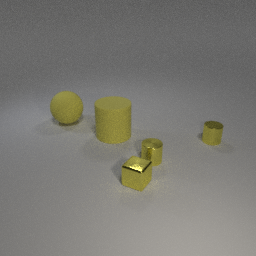

Label is: {('cylinder', 'yellow', 'rubber', 'large'): 1, ('cube', 'yellow', 'metal', 'small'): 1, ('sphere', 'yellow', 'rubber', 'large'): 1, ('cylinder', 'yellow', 'metal', 'small'): 2}


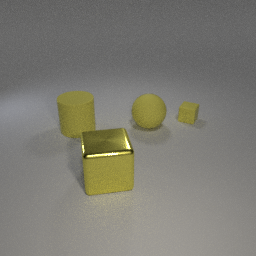

Label is: {('cube', 'yellow', 'rubber', 'small'): 1, ('sphere', 'yellow', 'rubber', 'large'): 1, ('cube', 'yellow', 'metal', 'large'): 1, ('cylinder', 'yellow', 'rubber', 'large'): 1}


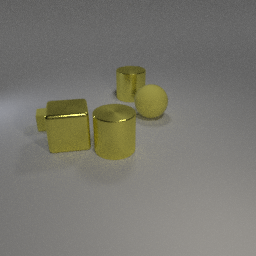

Label is: {('cube', 'yellow', 'metal', 'large'): 1, ('cylinder', 'yellow', 'metal', 'large'): 2, ('sphere', 'yellow', 'rubber', 'large'): 1, ('cube', 'yellow', 'rubber', 'small'): 1}


In [67]:
# Change this to say which CLEVR dataset we want to check.
# NOTE: We want to make sure that the images all have this property of dataset.
dataset = "yellow"

data_path = f"../clevr-dataset-gen/output/clevr_datasets/{dataset}/"
images = glob.glob(data_path + "images/*")
random.shuffle(images)

task_properties = ["shapes", "colors", "materials", "sizes"]
join_labels_flag = True
for im_path in images[:3]:
    display(Image.open(im_path))
    json_path = data_path + f"scenes/CLEVR_new_{im_path[-10:-4]}.json"
    print(f"Label is: {parse_obj_properties_from_json(json_path, task_properties, join_labels_flag)}")

In [53]:
# Plotting the images from their png file -> np array -> plt.imshow.
# path = '../../clevr-dataset-gen/output/'
# image_path = f"{path}images/"
# image_list = glob.glob(image_path + "*")
# for im_path in image_list:
#     pil_im = Image.open(im_path)
#     plt.imshow(np.asarray(pil_im))

lst_temp = [0]
lst_temp.insert(0, 5)
lst_temp

[5, 0]

In [3]:
# Getting the training mean, std values.
train_path = '../../clevr-dataset-gen/output/train/images/'
rgb_mean, rgb_std = calc_trainset_mean_std(train_path)


100%|██████████| 10000/10000 [08:04<00:00, 20.66it/s]


In [5]:
rgb_mean_copy = load_pickle("../data/rgb_mean.pickle")
rgb_std_copy = load_pickle("../data/rgb_std.pickle")

print(rgb_mean_copy)
print(rgb_std_copy)

[0.47035027 0.46635654 0.45921228]
[0.09705831 0.09378762 0.09461603]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([5, 3, 2])
tensor([3, 3, 2])
tensor([0, 3, 2])
tensor([3, 1, 3])


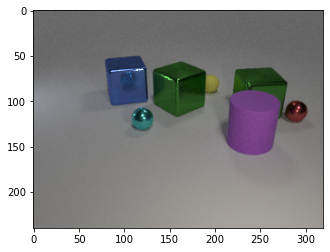

In [53]:
# Getting some images and labels from the trainloader and verifying them.
# Here, the images are un-standardized first.
im1, l1 = next(iter(clevr_dataloader))

output_path = '../../clevr-dataset-gen/output/'
clevr_dataset = CLEVRDataset(output_path)
clevr_dataloader = torch.utils.data.DataLoader(dataset=clevr_dataset, batch_size=4, shuffle=False)

for im, l in zip(im1, l1):
    x = im * rgb_std[:, None, None] + rgb_mean[:, None, None]
    plt.imshow(x.numpy().transpose(1,2,0))
    
    print(l)

In [31]:
# Getting the distribution of labels for each object.
cube_labels = [0] * 11
cylinder_labels = [0] * 11
sphere_labels = [0] * 11

In [32]:
train_dataset = CLEVRDataset('../../clevr-dataset-gen/output/')
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1, shuffle=True)

In [33]:
for i, (_, labels) in tqdm(enumerate(train_loader, 0)):
    lbl = labels.squeeze()
    cube_labels[lbl[0]] += 1
    cylinder_labels[lbl[1]] += 1
    sphere_labels[lbl[2]] += 1

123it [00:00, 139.36it/s]


In [34]:
print(cube_labels)
print(cylinder_labels)
print(sphere_labels)

[27, 28, 19, 15, 14, 9, 5, 4, 1, 0, 1]
[25, 24, 18, 13, 12, 12, 7, 4, 7, 1, 0]
[29, 23, 15, 16, 13, 16, 5, 4, 1, 0, 1]


Text(0.5, 1.0, 'Cube Label Distribution')

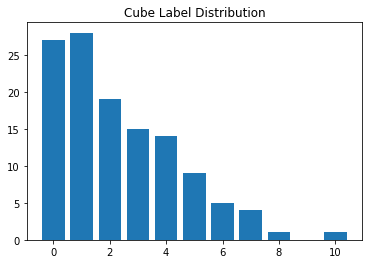

In [35]:
plt.bar(list(range(11)),cube_labels)
plt.title("Cube Label Distribution")

<BarContainer object of 11 artists>

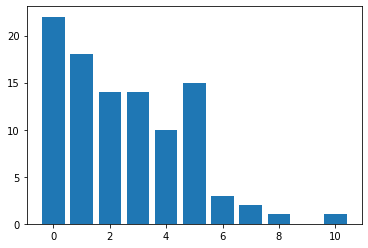

In [29]:
plt.bar(list(range(11)),sphere_labels)

<BarContainer object of 11 artists>

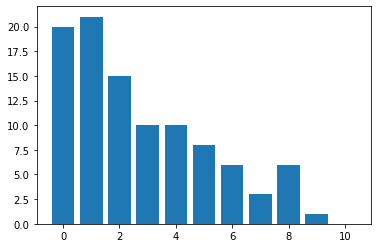

In [30]:
plt.bar(list(range(11)),cylinder_labels)



In [11]:
from itertools import product
res = [ele for ele in product(range(0,11), repeat=3)]

In [13]:
len(res)

1331

In [14]:
restricted_res = [x for x in res if sum(x) <= 10]

In [15]:
len(restricted_res)

286

In [19]:
cube_labels = [0] * 11
cylinder_labels = [0] * 11
sphere_labels = [0] * 11

for lbl in restricted_res:
    cube_labels[lbl[0]] += 1
    cylinder_labels[lbl[1]] += 1
    sphere_labels[lbl[2]] += 1

<BarContainer object of 11 artists>

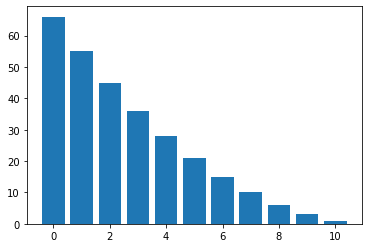

In [24]:
plt.bar(list(range(11)),cube_labels)

In [25]:
np.random.choice(restricted_res)

ValueError: a must be 1-dimensional

In [40]:
restricted_res[np.random.randint(0, len(restricted_res))]

(3, 6, 0)

In [4]:
num_objects = [3,3,3]
object_mapping = [1,2,3]

In [6]:
chosen_objects = [object_mapping[0]] * num_objects[0] + \
               [object_mapping[1]] * num_objects[1] + \
               [object_mapping[2]] * num_objects[2]

In [7]:
chosen_objects

[1, 1, 1, 2, 2, 2, 3, 3, 3]

In [13]:
tst = [object_mapping[i] for i in range(3) for _ in range(num_objects[i])]

In [14]:
tst

[1, 1, 1, 2, 2, 2, 3, 3, 3]